# Data Analysis:
## Predicting Customer Churn in SyriaTel's US Clients

This project is an analysis of customer churn based on anonymized data provided by Flatiron School's curated list of Phase 3 project datasets via [Kaggle.com](https://www.kaggle.com/datasets/becksddf/churn-in-telecoms-dataset).

The premise is to build a classifier to predict whether a customer will discontinue their prepaid mobile phone plan with telecom provider SyriaTel.

# Business & Data Understanding

Churn in the Telecommunications industry is at an all time low however SyriaTel is currently looking at a 14.5% attrition rate. For reference, our competitors reported an average of 2.31% 2022 4th quarter prepaid churn rate.

This notebook aims to identify attributes that will most likely predict customer churn by analyzing data reported by SyriaTel.

In [6]:
# Import necessary functions

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report

from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

sns.set(font_scale = 1)

# DATA CLEANING

In [7]:
# Import main dataset as dataframe

df = pd.read_csv('Data/churn.csv')

There are only 3 **area code** values across numerous states - something is off with this column so we'll drop it along with the **phone number** column. We will also convert non-numeric values to integers and make sure that there are no null values.

In [8]:
# Dropping unnecessary columns and viewing results
# 
df_clean = df.drop(columns=['area code', 'phone number'], axis=1)
df_clean['international plan'].replace(['no','yes'], [0,1], inplace = True)
df_clean['voice mail plan'].replace(['no','yes'], [0,1], inplace = True)
df_clean['churn'].replace([False, True], [0,1], inplace = True)

df_clean.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [9]:
df_clean['churn'].value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [10]:
# Viewing summary statistics

df_clean.describe()

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,0.096910,0.276628,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914
std,39.822106,0.295879,0.447398,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,0.000000,0.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000
50%,101.000000,0.000000,0.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,127.000000,0.000000,1.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000
max,243.000000,1.000000,1.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


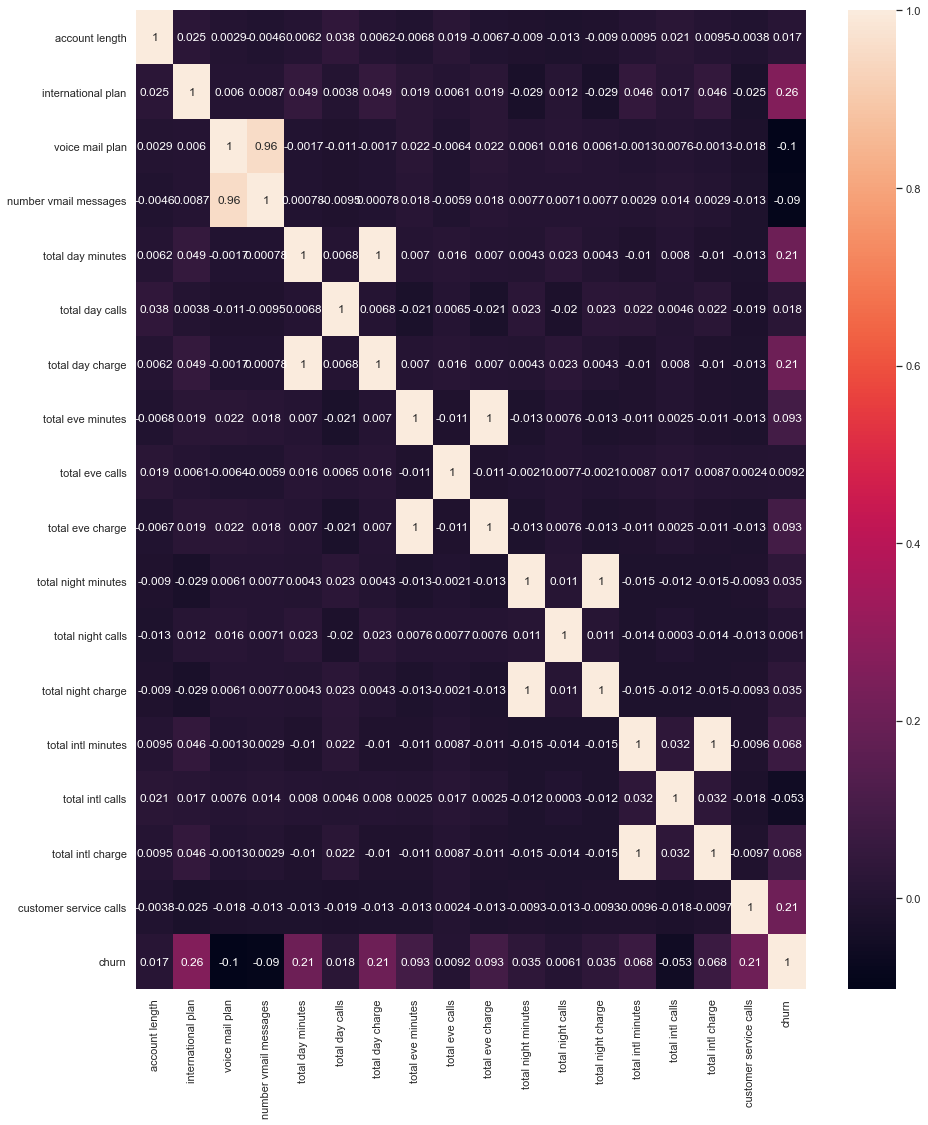

In [11]:
# Correlation heatmap for intial cleansed dataset

fig, ax = plt.subplots(figsize=(15, 18))

sns.heatmap(df_clean.corr(), annot=True);

Based on this map, it appears **international plan** has the highest correlation with **churn**, which we'll be using as our target. There also appears to be a three-way tie amongst **total day minutes**, **total day charge**, and **customer service calls** for the second highest correlation to **churn**.

# BUILDING FIRST SIMPLE MODEL (DECISION TREE CLASSIFIER)

In [12]:
# Separate data into feature and target DataFrames
X = df_clean.drop(columns = ['churn', 'state'], axis = 1)
y = df_clean['churn']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1)

# Create model
dtc_model1 = DecisionTreeClassifier(max_depth = 2, random_state=42)

# fit the model
dtc_model1.fit(X_train, y_train)

# get importance
importance = dtc_model1.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

# Accuracy on training data & test data
print('Training:', dtc_model1.score(X_train, y_train))
print('Testing:', dtc_model1.score(X_test, y_test))

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.41201
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.17256
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.41543
Training: 0.8803521408563425
Testing: 0.8693045563549161


In [13]:
prediction = dtc_model1.predict(X_test)

print ('\n clasification report:\n', classification_report(y_test,prediction))


 clasification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       712
           1       0.69      0.20      0.31       122

    accuracy                           0.87       834
   macro avg       0.78      0.59      0.62       834
weighted avg       0.85      0.87      0.84       834



In [14]:
# Separate data into feature and target DataFrames
X = df_clean.drop(columns = ['customer service calls', 'state'], axis = 1)
y = df_clean['customer service calls']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1)

# Create model
dtc_model_csc = DecisionTreeClassifier(max_depth = 2, random_state=42)

# fit the model
dtc_model_csc.fit(X_train, y_train)

# get importance
importance = dtc_model_csc.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

# Accuracy on training data & test data
print('Training:', dtc_model_csc.score(X_train, y_train))
print('Testing:', dtc_model_csc.score(X_test, y_test))

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.15523
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.37288
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.47189
Training: 0.3585434173669468
Testing: 0.3776978417266187


# SECOND DTC MODEL USING MORE DEPTH

In [15]:
# Separate data into feature and target DataFrames
X = df_clean.drop(columns = ['churn', 'state'], axis = 1)
y = df_clean['churn']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1)

# Create model with increased max_depth
dtc_model2 = DecisionTreeClassifier(max_depth = 5, random_state=42)

# fit the model
dtc_model2.fit(X_train, y_train)

# get importance
importance = dtc_model2.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

# Accuracy on training data & test data
print('Training:', dtc_model2.score(X_train, y_train))
print('Testing:', dtc_model2.score(X_test, y_test))

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.09980
Feature: 2, Score: 0.05771
Feature: 3, Score: 0.01002
Feature: 4, Score: 0.20839
Feature: 5, Score: 0.00808
Feature: 6, Score: 0.10453
Feature: 7, Score: 0.09222
Feature: 8, Score: 0.00768
Feature: 9, Score: 0.04018
Feature: 10, Score: 0.01663
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00573
Feature: 13, Score: 0.10006
Feature: 14, Score: 0.08239
Feature: 15, Score: 0.00563
Feature: 16, Score: 0.16094
Training: 0.9555822328931572
Testing: 0.9280575539568345


# THIRD DTC MODEL USING CROSS VALIDATION

The algorithm is defined with any required hyperparameters (we will use the defaults), then we will use repeated stratified k-fold cross-validation to evaluate the model. We will use three repeats of 10-fold cross-validation, meaning that 10-fold cross-validation is applied three times fitting and evaluating 30 models on the dataset.

The dataset is stratified, meaning that each fold of the cross-validation split will have the same class distribution as the original dataset. We will evaluate the model using the ROC area under curve (AUC) metric. This can be optimistic for severely imbalanced datasets but will still show a relative change with better performing models.

In [16]:
# Separate data into feature and target DataFrames
X = df_clean.drop(columns = ['churn', 'state'], axis = 1)
y = df_clean['churn']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1)

# define model
dtc_model3 = DecisionTreeClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(dtc_model3, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.774


In [17]:
# fit the model
dtc_model3.fit(X_train, y_train)

# get importance
importance = dtc_model3.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.01624
Feature: 1, Score: 0.07244
Feature: 2, Score: 0.04729
Feature: 3, Score: 0.01139
Feature: 4, Score: 0.21154
Feature: 5, Score: 0.01822
Feature: 6, Score: 0.06389
Feature: 7, Score: 0.10866
Feature: 8, Score: 0.02286
Feature: 9, Score: 0.04779
Feature: 10, Score: 0.04233
Feature: 11, Score: 0.02897
Feature: 12, Score: 0.02143
Feature: 13, Score: 0.01950
Feature: 14, Score: 0.07227
Feature: 15, Score: 0.07847
Feature: 16, Score: 0.11673


# FOURTH DTC MODEL USING SMOTE

Now, we can try the same model and the same evaluation method, although use a SMOTE transformed version of the dataset. This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model. This pipeline can then be evaluated using repeated k-fold cross-validation.

In [18]:
# Separate data into feature and target DataFrames
X = df_clean.drop(columns = ['churn', 'state'], axis = 1)
y = df_clean['churn']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1)

# define pipeline
steps = [('over', SMOTE()), ('model', DecisionTreeClassifier())]
dtc_model4 = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(dtc_model4, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.737


# DTC MODEL EVALUATION AND COMPARISON

In [19]:
# Separate data into feature and target DataFrames
X = df_clean.drop(columns = ['churn', 'state'], axis = 1)
y = df_clean['churn']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1)

# fit the model
dtc_model3.fit(X_train, y_train)
dtc_model4.fit(X_train, y_train)

# get predictions for each of the 3 models
prediction1 = dtc_model1.predict(X_test)
prediction2 = dtc_model2.predict(X_test)
prediction3 = dtc_model3.predict(X_test)
prediction4 = dtc_model4.predict(X_test)

print ('\n clasification report 1:\n', classification_report(y_test,prediction1))
print ('\n clasification report 2:\n', classification_report(y_test,prediction2))
print ('\n clasification report 3:\n', classification_report(y_test,prediction3))
print ('\n clasification report 4:\n', classification_report(y_test,prediction4))


 clasification report 1:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       712
           1       0.69      0.20      0.31       122

    accuracy                           0.87       834
   macro avg       0.78      0.59      0.62       834
weighted avg       0.85      0.87      0.84       834


 clasification report 2:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       712
           1       0.80      0.68      0.73       122

    accuracy                           0.93       834
   macro avg       0.87      0.83      0.85       834
weighted avg       0.92      0.93      0.93       834


 clasification report 3:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95       712
           1       0.66      0.75      0.70       122

    accuracy                           0.91       834
   macro avg       0.81      0.84      0.83    

In [20]:
print ('\n confussion matrix 1:\n',confusion_matrix(y_test, prediction1))
print ('\n confussion matrix 2:\n',confusion_matrix(y_test, prediction2))
print ('\n confussion matrix 3:\n',confusion_matrix(y_test, prediction3))
print ('\n confussion matrix 4:\n',confusion_matrix(y_test, prediction4))


 confussion matrix 1:
 [[701  11]
 [ 98  24]]

 confussion matrix 2:
 [[691  21]
 [ 39  83]]

 confussion matrix 3:
 [[665  47]
 [ 30  92]]

 confussion matrix 4:
 [[610 102]
 [ 28  94]]


The third DTC model has a high accuracy score, the highest recall score, and the fewest false negatives. We are aiming to reduce the number of false negatives because we want to avoid predicting a customer won't churn when in fact they have. Although the fourth model produces the same recall score and same number of false negatives, it is less accurate overall due to predicting a high number of false positives.

# FIRST SIMPLE MODEL (LOGISTIC REGRESSION)

In [21]:
# Separate data into feature and target DataFrames
X = df_clean.drop(columns = ['churn', 'state', 'total day charge'], axis = 1)
y = df_clean['churn']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1)

# Scale the data for Logistic Regression modeling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

# Train a logistic regresssion model with the train data
log_model = LogisticRegression(random_state=42)
log_model.fit(X_train_sc, y_train)

LogisticRegression(random_state=42)

In [22]:
# Accuracy on training data & test data
print('Training:', log_model.score(X_train_sc, y_train))
print('Testing:', log_model.score(X_test_sc, y_test))

Training: 0.8651460584233693
Testing: 0.8525179856115108


In [23]:
# get importance
importance = log_model.coef_[0]

# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.04128
Feature: 1, Score: 0.59999
Feature: 2, Score: -0.69448
Feature: 3, Score: 0.26208
Feature: 4, Score: 0.69623
Feature: 5, Score: 0.04157
Feature: 6, Score: 0.18111
Feature: 7, Score: 0.03499
Feature: 8, Score: 0.18108
Feature: 9, Score: 0.10800
Feature: 10, Score: -0.00475
Feature: 11, Score: 0.10626
Feature: 12, Score: 0.11599
Feature: 13, Score: -0.33071
Feature: 14, Score: 0.11971
Feature: 15, Score: 0.72105


In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2499 entries, 2654 to 1061
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          2499 non-null   int64  
 1   international plan      2499 non-null   int64  
 2   voice mail plan         2499 non-null   int64  
 3   number vmail messages   2499 non-null   int64  
 4   total day minutes       2499 non-null   float64
 5   total day calls         2499 non-null   int64  
 6   total eve minutes       2499 non-null   float64
 7   total eve calls         2499 non-null   int64  
 8   total eve charge        2499 non-null   float64
 9   total night minutes     2499 non-null   float64
 10  total night calls       2499 non-null   int64  
 11  total night charge      2499 non-null   float64
 12  total intl minutes      2499 non-null   float64
 13  total intl calls        2499 non-null   int64  
 14  total intl charge       2499 non-null

In [25]:
predictions = log_model.predict(X_test_sc)
  
# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       712
           1       0.49      0.18      0.26       122

    accuracy                           0.85       834
   macro avg       0.68      0.57      0.59       834
weighted avg       0.82      0.85      0.82       834



# SECOND LOG REG MODEL USING SMOTE

In [26]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  
# Using SMOTE to balance data
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_sample(X_train_sc, y_train)
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 361
Before OverSampling, counts of label '0': 2138 

After OverSampling, the shape of train_X: (4276, 16)
After OverSampling, the shape of train_y: (4276,) 

After OverSampling, counts of label '1': 2138
After OverSampling, counts of label '0': 2138


In [27]:
log_model_bal = LogisticRegression(random_state=42)
log_model_bal.fit(X_train_res, y_train_res)
predictions = log_model_bal.predict(X_test_sc)
  
# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84       712
           1       0.34      0.72      0.46       122

    accuracy                           0.76       834
   macro avg       0.64      0.74      0.65       834
weighted avg       0.85      0.76      0.79       834



# USING GRIDSEARCH TO REFINE HYPERPARAMETERS

In [28]:
import warnings
warnings.filterwarnings('ignore')

# parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

logreg = LogisticRegression()
clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds

# Fit the model on scaled training data
clf.fit(X_train_sc, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [29]:
print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

Tuned Hyperparameters : {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy : 0.8643469879518072


# LOG REG MODEL WITH TUNED HYPERPARAMETERS

In [30]:
logreg = LogisticRegression(C = 0.01, 
                            penalty = 'l2', 
                            solver = 'newton-cg')
logreg.fit(X_train_sc, y_train)
y_pred = logreg.predict(X_test_sc)

# print accuracy and classification report
print("Accuracy:",logreg.score(X_test_sc, y_test))
print(classification_report(y_test, y_pred))

Accuracy: 0.8561151079136691
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       712
           1       0.55      0.09      0.15       122

    accuracy                           0.86       834
   macro avg       0.71      0.54      0.54       834
weighted avg       0.82      0.86      0.81       834



In [31]:
print ('\n confussion matrix :\n',confusion_matrix(y_test, y_pred))


 confussion matrix :
 [[703   9]
 [111  11]]


# GRIDSEARCH ON ENTIRE DATASET

In [32]:
# Separate data into feature and target DataFrames
X = df_clean.drop(columns = ['churn', 'state', 'total day minutes'], axis = 1)
y = df_clean['churn']

parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}
logreg = LogisticRegression()
clf = GridSearchCV(logreg, 
                   param_grid = parameters,
                   scoring = 'accuracy', 
                   cv = 10)
clf.fit(X,y)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [33]:
print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

Tuned Hyperparameters : {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy : 0.8619850389311468


# BUILDING FINAL MODEL WITH SCALED & BALANCED DATA AND TUNED HYPERPARAMETERS

In [34]:
# Separate data into feature and target DataFrames
X = df_clean.drop(columns = ['churn', 'state', 'total day minutes'], axis = 1)
y = df_clean['churn']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1)

# Scale the data for Logistic Regression modeling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

# Using SMOTE to balance data
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_sample(X_train_sc, y_train)

log_model_final = LogisticRegression(C = 1.0, 
                            penalty = 'l1', 
                            solver = 'liblinear',
                            random_state=42)
log_model_final.fit(X_train_res, y_train_res)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

In [35]:
# Evaluation metrics

y_pred = log_model_final.predict(X_test_sc)

print(classification_report(y_test, y_pred))
print ('\n confusion matrix :\n',confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84       712
           1       0.34      0.72      0.46       122

    accuracy                           0.76       834
   macro avg       0.64      0.74      0.65       834
weighted avg       0.85      0.76      0.79       834


 confusion matrix :
 [[542 170]
 [ 34  88]]


The final model is fairly accurate and has the highest recall score among our logistic regression models.

In [36]:
log_odds = log_model_final.coef_[0]
pd.DataFrame(log_odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
customer service calls,0.956576
total day charge,0.819989
international plan,0.699781
number vmail messages,0.417200
total eve minutes,0.304439
total intl charge,0.217158
total night charge,0.139333
total night minutes,0.113749
total eve calls,0.080653
total eve charge,0.077481


Because of the logit function, logistic regression coefficients represent the log odds that an observation is in the target class (“1”) given the values of its X variables. Thus, these log odd coefficients need to be converted to regular odds in order to make sense of them.

In [37]:
odds = np.exp(log_model_final.coef_[0])
odds_chart = pd.DataFrame(odds, 
                          X.columns, 
                          columns=['coef'])\
                          .sort_values(by='coef', ascending=False)

odds_chart.reset_index(drop=False, inplace=True)
odds_chart

,index,coef
0,customer service calls,2.602770
1,total day charge,2.270475
2,international plan,2.013312
3,number vmail messages,1.517706
4,total eve minutes,1.355864
5,total intl charge,1.242540
6,total night charge,1.149507
7,total night minutes,1.120471
8,total eve calls,1.083995
9,total eve charge,1.080562


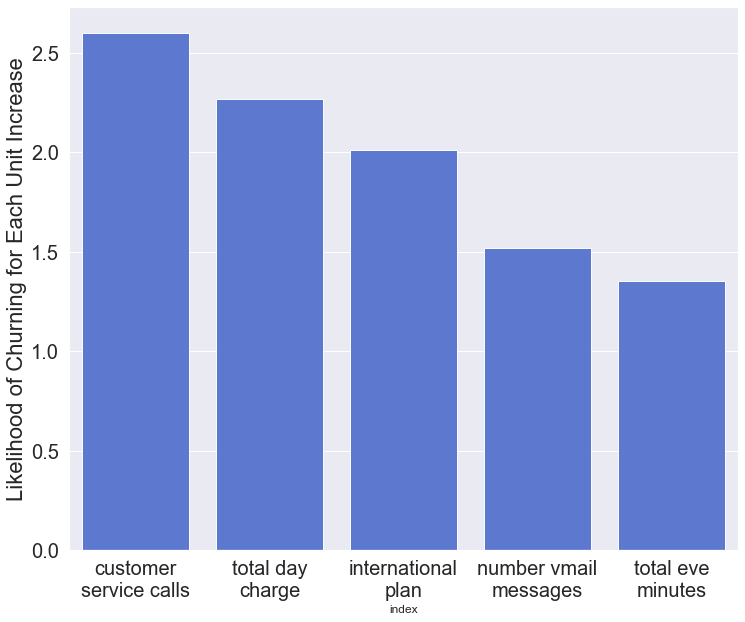

In [38]:
# Plot the Total Sum of Account Lengths by Customer Service Calls
import textwrap

fig, ax = plt.subplots(figsize = (12 , 10))

fig = sns.barplot(data = odds_chart.head(),
                  x = 'index',
                  y = 'coef',
                  color = 'royalblue',
                  alpha=0.95)

#plt.xlabel('Number of Customer Service Calls', size=20)
labels = [textwrap.fill(label.get_text(), 15) for label in ax.get_xticklabels()]
ax.set_xticklabels(labels);
plt.xticks(fontsize=20)
plt.ylabel('Likelihood of Churning for Each Unit Increase', size=22)
plt.yticks(fontsize=20)
#plt.title('Top 5 Factors in Customer Churn', size=20)
plt.show(fig);

# IDENTIFYING ATTRIBUTES OF CUSTOMERS MOST LIKELY TO CHURN

Based on our model, we are able to retrospectively predict a probability that a customer would have churned. Those probabilities indicate behavioral threshholds that could mean that a customer is likely to churn.

In [40]:
# new data frame with our top 5 variables of interest

final_results = X_test.copy()

final_results = pd.concat([final_results, y_test], axis=1)
final_results = pd.DataFrame(final_results)
final_results = final_results[['customer service calls', 
                               'total day charge', 
                               'international plan', 
                               'number vmail messages',
                               'voice mail plan',
                               'total eve charge', 
                               'total intl charge',
                              ]]

In [41]:
#probability score for each customer
y_pred_probs = log_model_final.predict_proba(X_test_sc)
y_pred_probs = y_pred_probs [:, 1]

In [42]:
#adding our predictions and the scores to the data frame
final_results['predictions'] = y_pred
final_results["propensity to churn %"] = y_pred_probs

final_results.head()

,customer service calls,total day charge,international plan,number vmail messages,voice mail plan,total eve charge,total intl charge,predictions,propensity to churn %
2360,2,37.76,0,0,0,16.95,2.54,1,0.536502
600,2,17.44,0,0,0,20.91,2.46,0,0.166838
1501,0,46.31,0,0,0,9.17,3.43,0,0.346495
1114,1,28.07,0,15,1,22.70,2.94,0,0.131649
517,2,36.50,0,0,0,13.48,2.54,0,0.354584


In [43]:
#calculating probability for a customer's propensity to churn
final_results['propensity to churn %'] = final_results["propensity to churn %"]*100
final_results["propensity to churn %"]=final_results["propensity to churn %"].round(2)

#ranking those customers likely to churn by priority 1 through 10

final_results ['ranking'] = pd.qcut(final_results['propensity to churn %'].rank(method = 'first'),10,labels=range(10,0,-1))
final_results.head()

,customer service calls,total day charge,international plan,number vmail messages,voice mail plan,total eve charge,total intl charge,predictions,propensity to churn %,ranking
2360,2,37.76,0,0,0,16.95,2.54,1,53.65,3
600,2,17.44,0,0,0,20.91,2.46,0,16.68,7
1501,0,46.31,0,0,0,9.17,3.43,0,34.65,5
1114,1,28.07,0,15,1,22.70,2.94,0,13.16,8
517,2,36.50,0,0,0,13.48,2.54,0,35.46,5


In [44]:
#new df with only priority 1 customers
priority1 = final_results[(final_results['ranking'] == 1)]
pd.set_option('display.max_rows', None)
priority1.sort_values(by=['propensity to churn %'], ascending=False).head()

,customer service calls,total day charge,international plan,number vmail messages,voice mail plan,total eve charge,total intl charge,predictions,propensity to churn %,ranking
2732,5,36.75,1,0,0,30.91,4.56,1,99.83,1
2380,9,38.86,0,0,0,11.29,2.73,1,99.56,1
2139,3,42.89,1,0,0,17.60,3.24,1,98.84,1
3304,4,31.64,1,0,0,16.88,3.73,1,98.14,1
351,4,37.42,1,38,1,19.92,2.73,1,97.98,1


In [45]:
#descriptive stats and visualization for priority 1 customers
priority1.describe()

,customer service calls,total day charge,international plan,number vmail messages,voice mail plan,total eve charge,total intl charge,predictions,propensity to churn %
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.0,84.000000
mean,3.464286,35.985595,0.488095,6.714286,0.214286,17.178571,2.885357,1.0,89.064405
std,1.772932,9.561428,0.502860,13.322299,0.412790,4.569781,0.714594,0.0,5.991622
min,0.000000,12.040000,0.000000,0.000000,0.000000,5.170000,1.430000,1.0,79.160000
25%,2.000000,28.552500,0.000000,0.000000,0.000000,14.595000,2.365000,1.0,83.535000
50%,3.500000,36.685000,0.000000,0.000000,0.000000,17.740000,2.825000,1.0,89.710000
75%,5.000000,41.785000,1.000000,0.000000,0.000000,19.355000,3.327500,1.0,94.127500
max,9.000000,57.040000,1.000000,41.000000,1.000000,30.910000,4.560000,1.0,99.830000


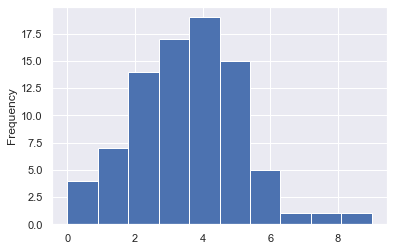

In [47]:
priority1['customer service calls'].plot(kind='hist');

In [48]:
priority1['customer service calls'].describe()

count    84.000000
mean      3.464286
std       1.772932
min       0.000000
25%       2.000000
50%       3.500000
75%       5.000000
max       9.000000
Name: customer service calls, dtype: float64

In [49]:
priority1['customer service calls'].value_counts()

4    19
3    17
5    15
2    14
1     7
6     5
0     4
9     1
8     1
7     1
Name: customer service calls, dtype: int64

In [50]:
priority1['total day minutes'].plot(kind='hist');

KeyError: 'total day minutes'

In [52]:
priority1['total day charge'].describe()

count    84.000000
mean     35.985595
std       9.561428
min      12.040000
25%      28.552500
50%      36.685000
75%      41.785000
max      57.040000
Name: total day charge, dtype: float64

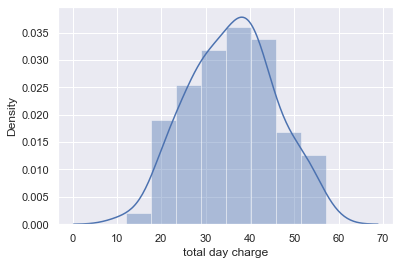

In [54]:
sns.distplot(priority1['total day charge']);

In [55]:
priority1['international plan'].value_counts()

0    43
1    41
Name: international plan, dtype: int64

In [56]:
priority1['number vmail messages'].value_counts()

0     66
21     2
36     2
31     1
20     1
23     1
24     1
28     1
29     1
41     1
40     1
33     1
35     1
37     1
38     1
39     1
32     1
Name: number vmail messages, dtype: int64

In [57]:
priority1['voice mail plan'].value_counts()

0    66
1    18
Name: voice mail plan, dtype: int64

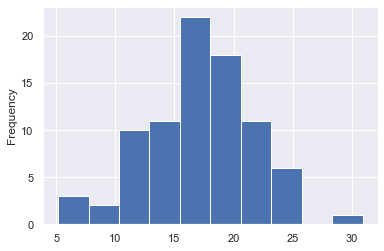

In [58]:
priority1['total eve charge'].plot(kind='hist');

In [59]:
priority1['total eve charge'].describe()

count    84.000000
mean     17.178571
std       4.569781
min       5.170000
25%      14.595000
50%      17.740000
75%      19.355000
max      30.910000
Name: total eve charge, dtype: float64

In [60]:
priority1['international plan'].value_counts()

0    43
1    41
Name: international plan, dtype: int64

In [61]:
priority1['total intl charge'].describe()

count    84.000000
mean      2.885357
std       0.714594
min       1.430000
25%       2.365000
50%       2.825000
75%       3.327500
max       4.560000
Name: total intl charge, dtype: float64

# On Average, Priority 1 Customers:

- `customer service calls`: call customer service between 2 and 5 times
- `total day minutes`: Have spoken on the phone during daytime hours between 200 and 275 minutes
- `international plan`: Are likely to have an international plan
- `total eve charge`: Have spent 15 - 18 dollars on evening phone calls
- `number vmail messages`: Likely don't have a voicemail plan or do not use it at all

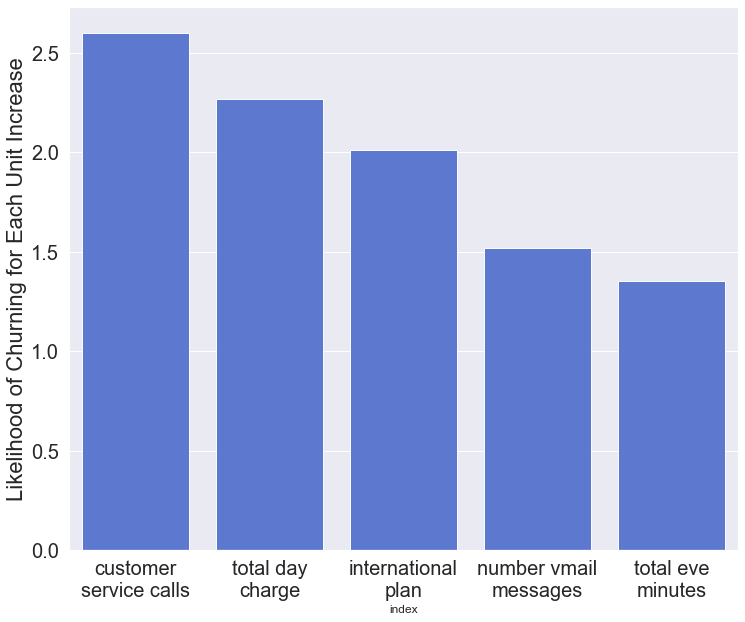

In [62]:
import textwrap

fig, ax = plt.subplots(figsize = (12 , 10))

fig = sns.barplot(data = odds_chart.head(),
                  x = 'index',
                  y = 'coef',
                  color = 'royalblue',
                  alpha=0.95)

#plt.xlabel('Number of Customer Service Calls', size=20)
labels = [textwrap.fill(label.get_text(), 15) for label in ax.get_xticklabels()]
ax.set_xticklabels(labels);
plt.xticks(fontsize=20)
plt.ylabel('Likelihood of Churning for Each Unit Increase', size=22)
plt.yticks(fontsize=20)
#plt.title('Top 5 Factors in Customer Churn', size=20)
plt.show(fig);

# CONCLUSION

## FINAL MODEL RESULTS

The following are the variables that most predict churn in this data set:
- `customer service calls`
- `total day charge`
- `international plan`
- `number of vmail messages`
-`total eve minutes`


So, as variable **customer service calls** increases by one unit, the odds that the customers represented in the observation are in the target class (“1”) are over 2.6x as large as the odds that they won’t be in the target class.